# 1. Модели прогназирование аномалий


In [1]:
!pip install --upgrade pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.3-py3-none-any.whl size=200466 sha256=a921970ab8cab48c44d41d8cd552715a3fc006b5fa43a558accc41b61a9b2b87
  Stored in directory: /root/.cache/pip/wheels/2d/60/5b/f74eccd2c9c892a2c298202ca510f10995f9940647fcc2d97f
Successfully built pyod


In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


In [3]:
!pip install scipy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from numpy import percentile
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use({'figure.facecolor':'white'})
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from datetime import timedelta

from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


from statsmodels.tsa.seasonal import seasonal_decompose
from pyod.models.hbos import HBOS
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.lscp import LSCP

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Временные ряды_и_книга/case2_data.csv')

In [7]:
data

,time,src_ip,requests
0,2021-03-31 13:53:30,25831,2
1,2021-03-31 13:53:30,93262,8
2,2021-03-31 10:55:00,618,5
3,2021-03-31 10:55:00,716,15
4,2021-03-31 10:55:00,1724,2
...,...,...,...
1264807,2021-03-31 09:41:30,105247,38
1264808,2021-03-31 09:41:30,106205,6
1264809,2021-03-31 09:41:30,106230,5
1264810,2021-03-31 09:41:30,106414,14


In [8]:
data['src_ip'].nunique()

106746

In [9]:
ip_requests_distribution = data.groupby('src_ip')['requests'].sum().sort_values(ascending=False)

# Find the top IP addresses with the maximum requests
top_ip_requests = ip_requests_distribution.head(10)

# Results
ip_requests_distribution.describe(), top_ip_requests

(count    106746.000000
 mean        129.704926
 std         523.778481
 min           1.000000
 25%          16.000000
 50%          41.000000
 75%         134.000000
 max       49146.000000
 Name: requests, dtype: float64,
 src_ip
 21612    49146
 97845    32194
 13661    30930
 98296    30371
 44091    30237
 13571    29852
 97434    29341
 30872    29327
 97582    28992
 98548    28155
 Name: requests, dtype: int64)

Создаем новые признаки, для определения аномальных запросов

In [10]:
def count_peaks(series):
    peaks = series[series > series.quantile(0.95)] #значения выше 95-го процентиля
    return len(peaks)

ip_requests_distribution_1 = data.groupby('src_ip')['requests'].agg(
    ['mean', 'median', 'max', 'min', 'std', 'sum', count_peaks]
)

In [11]:
ip_requests_distribution_1

,mean,median,max,min,std,sum,count_peaks
src_ip,,,,,,,
0,6.181818,5.0,14,1,5.325752,68,1
1,9.800000,4.0,33,1,13.479614,49,1
2,4.333333,1.0,11,1,5.773503,13,1
3,3.333333,1.0,8,1,4.041452,10,1
4,9.333333,13.0,14,1,7.234178,28,1
...,...,...,...,...,...,...,...
106741,35.000000,35.0,40,30,7.071068,70,1
106742,5.666667,7.0,9,1,4.163332,17,1
106743,19.428571,4.0,75,1,23.876974,272,1


Вычисляется коэффициент вариации (Coefficient of Variation, CV) для распределения запросов по IP-адресам

In [12]:
ip_requests_distribution_1['CV'] = ip_requests_distribution_1.apply(lambda row: row['std'] / row['mean'] if row['mean'] != 0
                                                                    and not np.isnan(row['std']) and not np.isnan(row['mean'])
                                                                    else 0, axis=1)

In [13]:
ip_requests_distribution_1

,mean,median,max,min,std,sum,count_peaks,CV
src_ip,,,,,,,,
0,6.181818,5.0,14,1,5.325752,68,1,0.861519
1,9.800000,4.0,33,1,13.479614,49,1,1.375471
2,4.333333,1.0,11,1,5.773503,13,1,1.332347
3,3.333333,1.0,8,1,4.041452,10,1,1.212436
4,9.333333,13.0,14,1,7.234178,28,1,0.775091
...,...,...,...,...,...,...,...,...
106741,35.000000,35.0,40,30,7.071068,70,1,0.202031
106742,5.666667,7.0,9,1,4.163332,17,1,0.734706
106743,19.428571,4.0,75,1,23.876974,272,1,1.228962


In [14]:
ip_requests_distribution_1 = ip_requests_distribution_1.drop(columns=['std', 'mean'])

In [15]:
ip_requests_distribution_1

,median,max,min,sum,count_peaks,CV
src_ip,,,,,,
0,5.0,14,1,68,1,0.861519
1,4.0,33,1,49,1,1.375471
2,1.0,11,1,13,1,1.332347
3,1.0,8,1,10,1,1.212436
4,13.0,14,1,28,1,0.775091
...,...,...,...,...,...,...
106741,35.0,40,30,70,1,0.202031
106742,7.0,9,1,17,1,0.734706
106743,4.0,75,1,272,1,1.228962


In [16]:
ip_requests_distribution_1.describe()

,median,max,min,sum,count_peaks,CV
count,106746.000000,106746.000000,106746.000000,106746.000000,106746.000000,106746.000000
mean,7.545290,25.819825,1.695876,129.704926,1.022586,0.727339
std,5.810336,27.064285,2.340388,523.778481,1.818523,0.436220
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,10.000000,1.000000,16.000000,1.000000,0.503322
50%,7.000000,18.000000,1.000000,41.000000,1.000000,0.795254
75%,10.000000,33.000000,1.000000,134.000000,1.000000,1.013938
max,103.000000,2165.000000,97.000000,49146.000000,147.000000,6.181274


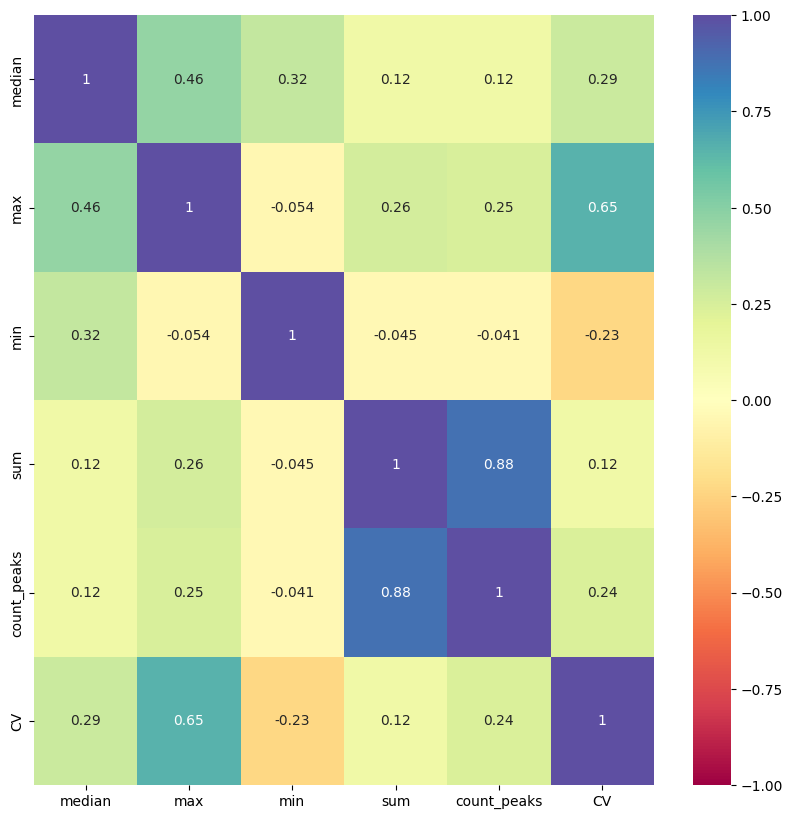

In [17]:
corr = ip_requests_distribution_1.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr,cmap="Spectral",annot=True,vmax=1,vmin=-1)
plt.show()

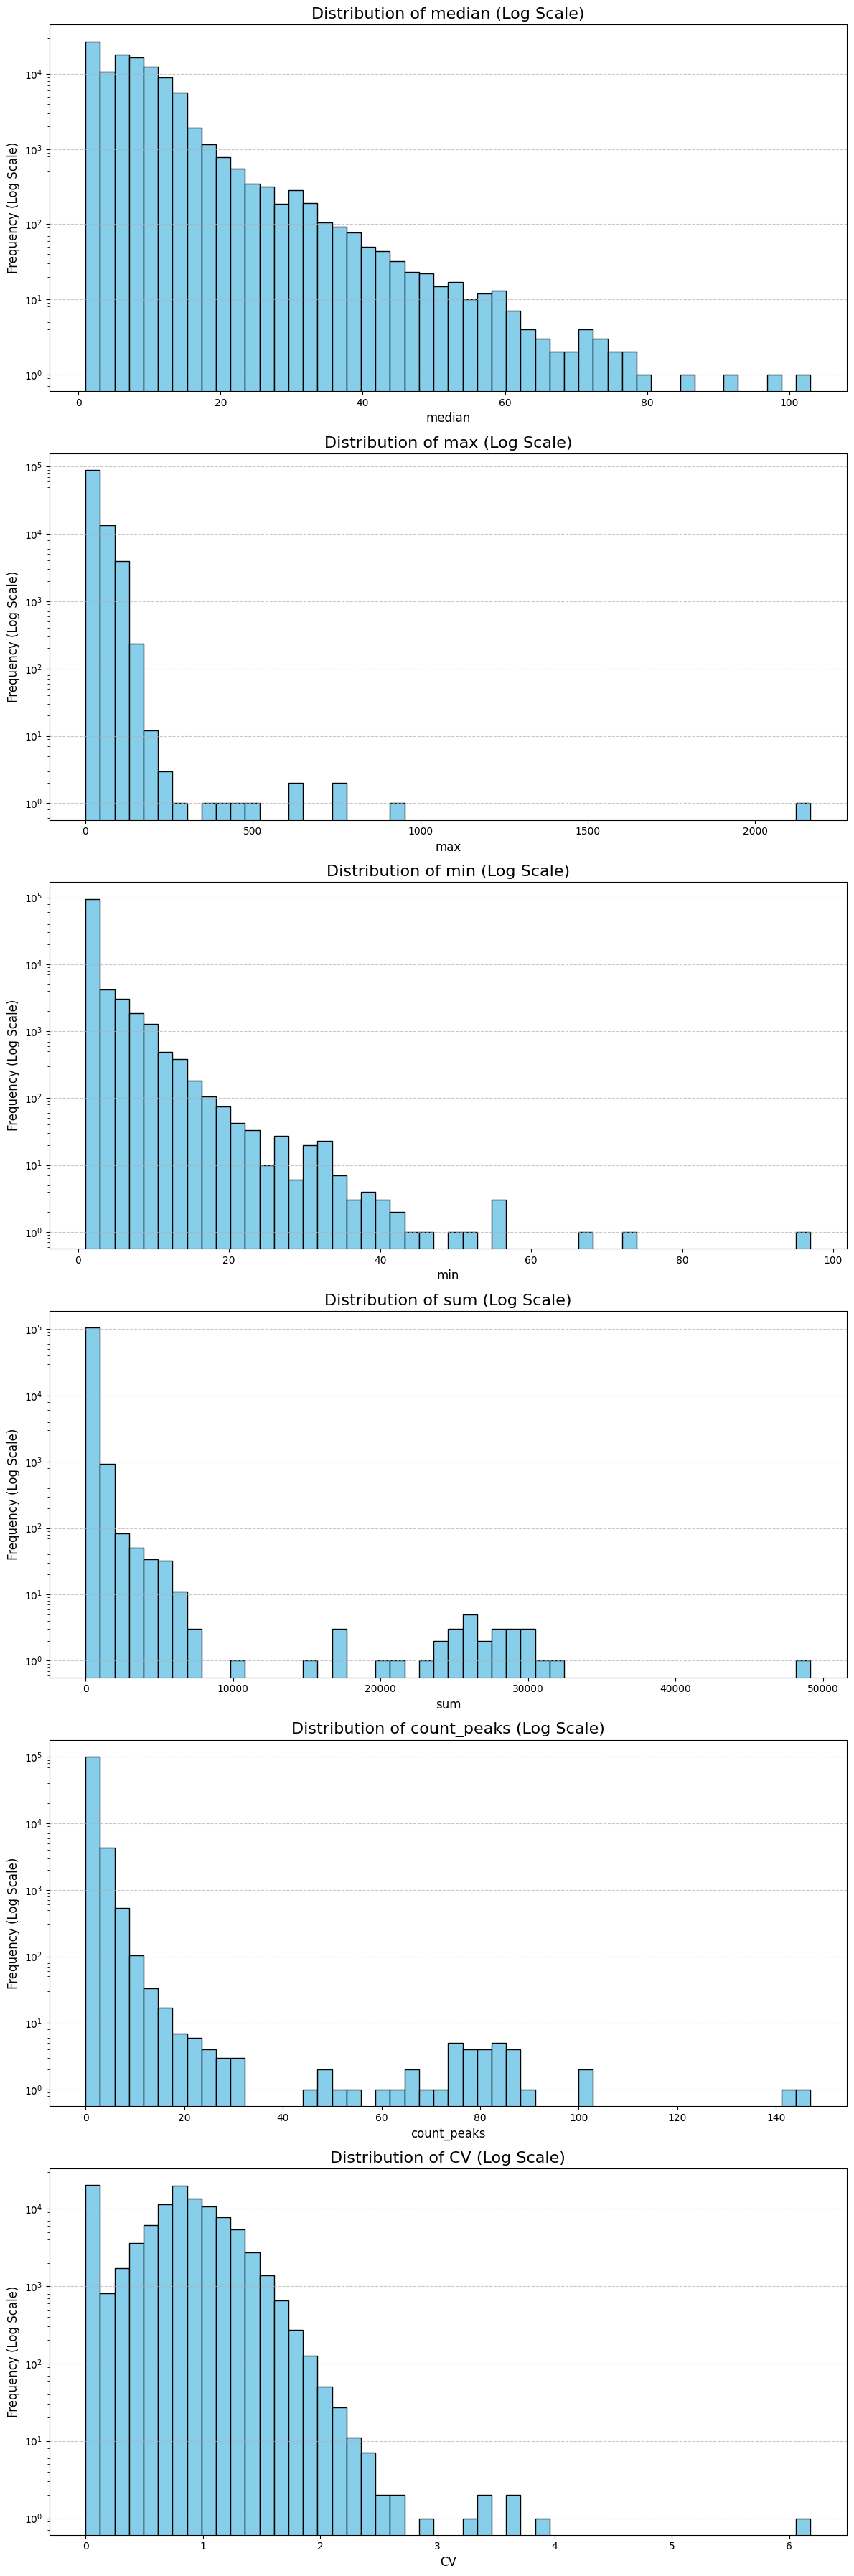

In [ ]:
# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=len(ip_requests_distribution_1.columns), ncols=1, figsize=(12, 6 * len(ip_requests_distribution_1.columns)))

# Перебираем столбцы и строим гистограммы
for i, column in enumerate(ip_requests_distribution_1.columns):
    axes[i].hist(ip_requests_distribution_1[column], bins=50, color='skyblue', edgecolor='black', log=True)
    axes[i].set_title(f'Distribution of {column} (Log Scale)', fontsize=16)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency (Log Scale)', fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Отображаем графики
plt.tight_layout()  # Для предотвращения перекрытия подграфиков
plt.show()

In [18]:
ip_requests_distribution = ip_requests_distribution_1.copy()

Логарифмирование признаков

In [19]:
columns_to_normalize = ip_requests_distribution.columns.difference(['src_ip'])

ip_requests_distribution[columns_to_normalize] = np.log10(ip_requests_distribution[columns_to_normalize] + 1)

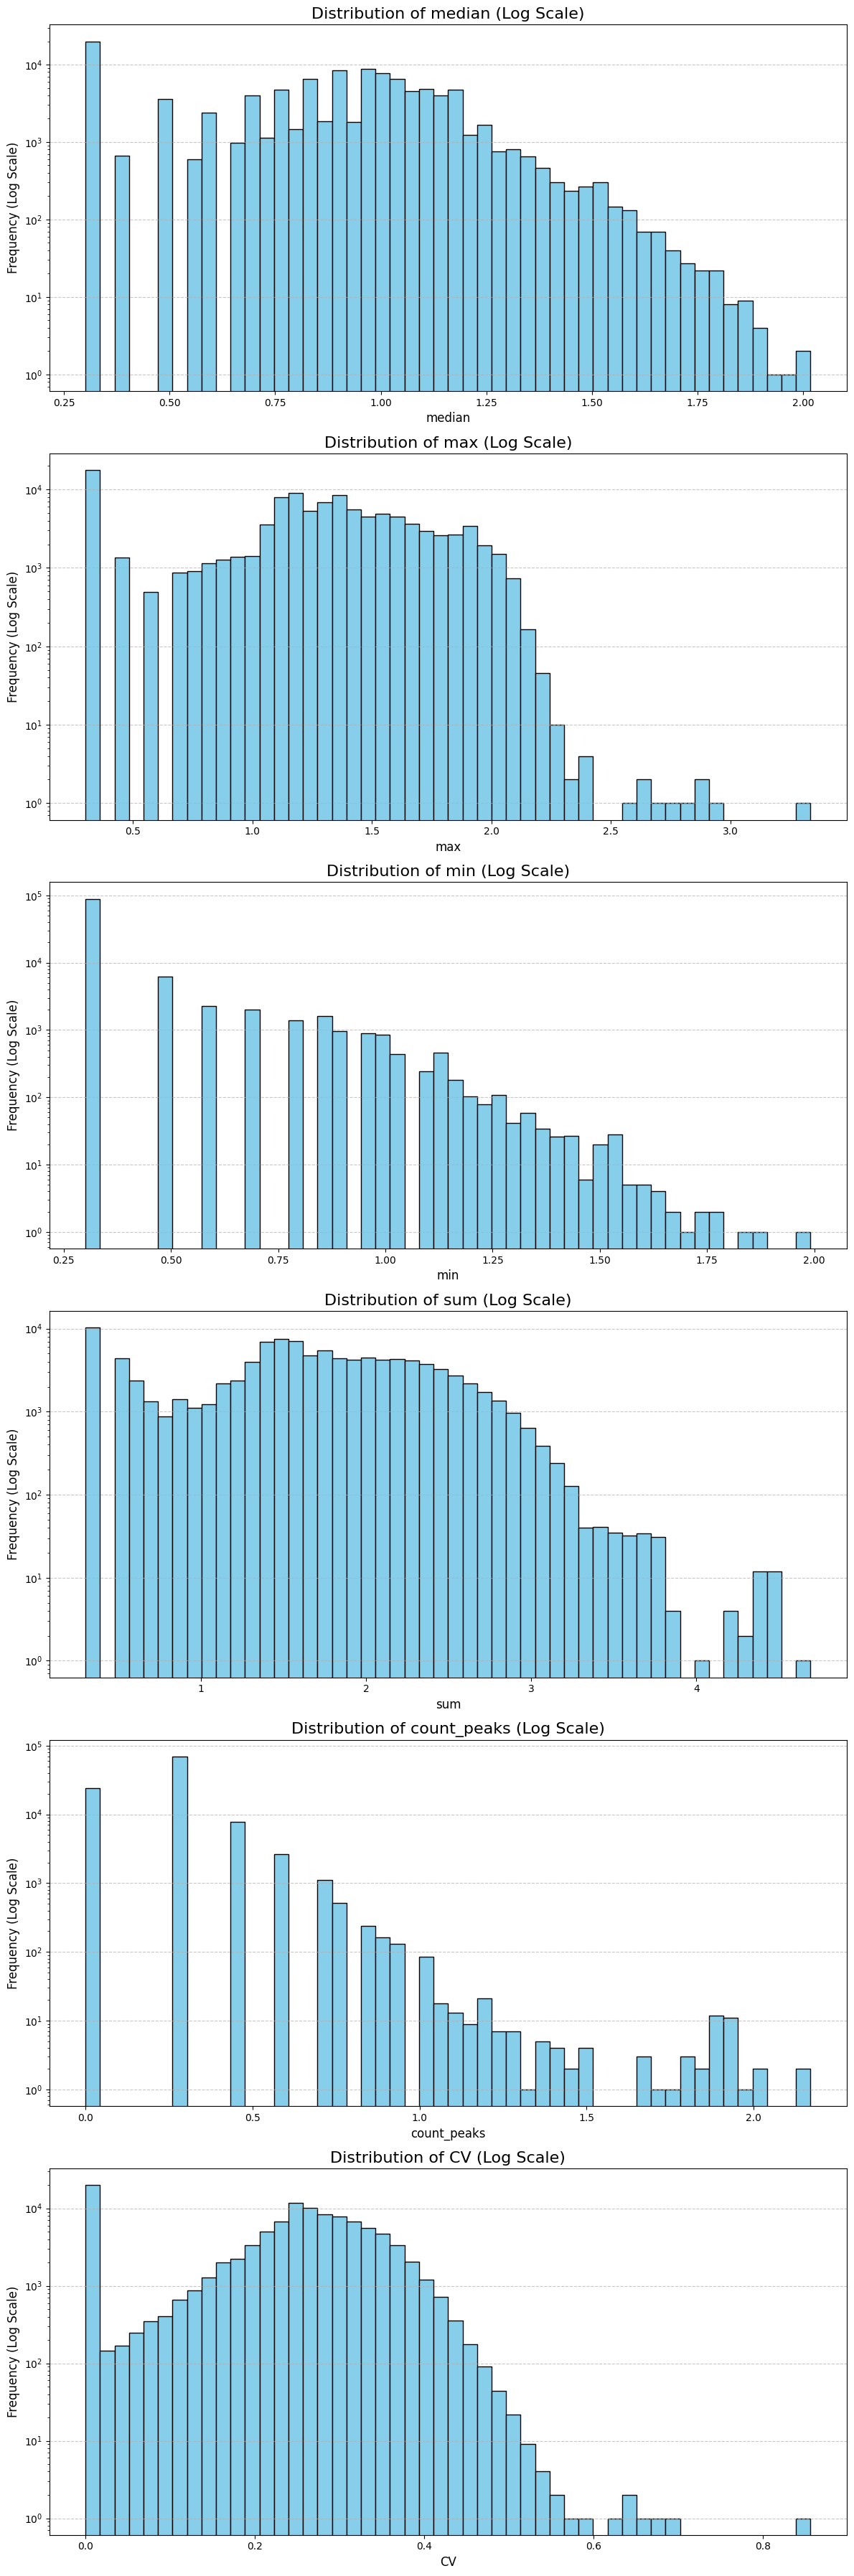

In [20]:
# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=len(ip_requests_distribution.columns), ncols=1, figsize=(12, 6 * len(ip_requests_distribution.columns)))

# Перебираем столбцы и строим гистограммы
for i, column in enumerate(ip_requests_distribution.columns):
    axes[i].hist(ip_requests_distribution[column], bins=50, color='skyblue', edgecolor='black', log=True)
    axes[i].set_title(f'Distribution of {column} (Log Scale)', fontsize=16)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency (Log Scale)', fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Отображаем графики
plt.tight_layout()  # Для предотвращения перекрытия подграфиков
plt.show()

Разделение данных на train и test

In [21]:
features = ip_requests_distribution.drop(columns=ip_requests_distribution.columns.difference(
    ['median', 'max', 'min', 'count_peaks', 'sum', 'CV']))
src_ip = ip_requests_distribution.index

In [ ]:
X_train, X_test, src_ip_train, src_ip_test = train_test_split(
    features, src_ip, test_size=0.2, random_state=42)

Нормализация MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train[columns_to_normalize])

X_test_scaler = scaler.fit_transform(X_test[columns_to_normalize])

X_train_new = pd.DataFrame(X_train_scaler, columns=columns_to_normalize, index=X_train.index)
X_test_new = pd.DataFrame(X_test_scaler, columns=columns_to_normalize, index=X_test.index)

In [ ]:
X_train_new.describe()

,CV,count_peaks,max,median,min,sum
count,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000
mean,0.258874,0.131806,0.297022,0.307865,0.041515,0.310597
std,0.142562,0.086044,0.164503,0.184910,0.107889,0.171260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.207048,0.149871,0.243971,0.175425,0.000000,0.221852
50%,0.296846,0.149871,0.322189,0.350850,0.000000,0.315613
75%,0.355155,0.149871,0.405469,0.431446,0.000000,0.436654
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_test_new.describe()

,CV,count_peaks,max,median,min,sum
count,21350.000000,21350.000000,21350.000000,21350.000000,21350.000000,21350.000000
mean,0.328340,0.121567,0.372958,0.317220,0.045921,0.295803
std,0.182563,0.081397,0.207707,0.191379,0.119550,0.164386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.262545,0.138707,0.289733,0.181043,0.000000,0.211690
50%,0.377438,0.138707,0.405281,0.362085,0.000000,0.301157
75%,0.452182,0.138707,0.515257,0.445262,0.000000,0.417384
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Модель CBLOF - для определения аномальных данных

Подбор оптимального количества кластеров для модели

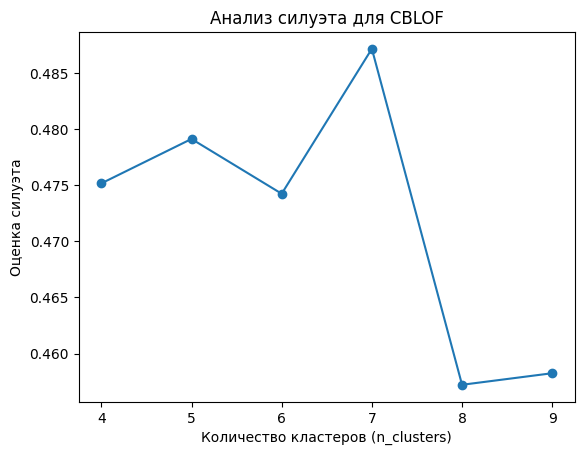

In [ ]:
# Создайте список потенциальных значений n_clusters
n_clusters_range = range(4, 10, 1)  # Пример: от 3 до 9 кластеров

# Инициализируйте списки для хранения оценок силуэта
silhouette_scores = []

# Итерируйте по различным значениям n_clusters
for n_clusters in n_clusters_range:
    # Создайте и обучите модель CBLOF
    cblof_model = CBLOF(n_clusters=n_clusters, contamination=0.003, random_state=42)
    cblof_model.fit(X_train_new)

    # Получите метки кластеров
    cluster_labels = cblof_model.labels_

    # Вычислите оценку силуэта и добавьте ее в список
    silhouette_scores.append(silhouette_score(X_train_new, cluster_labels))

# Постройте график оценок силуэта в зависимости от n_clusters
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel("Количество кластеров (n_clusters)")
plt.ylabel("Оценка силуэта")
plt.title("Анализ силуэта для CBLOF")
plt.show()

In [ ]:
# Создание модели CBLOF
cblof_model = CBLOF(
    n_clusters=7,               # Количество кластеров
    contamination=0.003,          # Доля выбросов
    alpha=0.9,                  # Параметр, определяющий крупные и малые кластеры
    beta=5,                     # Ограничение для крупных кластеров
    use_weights=False,          # Использовать веса для вычисления скорингов
    random_state=42,
    n_jobs=1
)

# Обучение модели на тренировочных данных
cblof_model.fit(X_train_new)

# Выбераем для X_test_new те же функции, которые использовались для обучения.
X_test_new_selected = X_test_new[X_train_new.columns] # Выберите столбцы, присутствующие в X_train_new

# Прогнозирование аномалий на тестовых данных
anomaly_labels_test = cblof_model.predict(X_test_new_selected)  # Метки аномалий (0 - нормальный, 1 - выброс)
anomaly_scores_test = cblof_model.decision_function(X_test_new_selected)  # Оценка аномальности (чем больше, тем вероятнее выброс)

# Add predictions to X_test DataFrame (or a copy if you want to preserve the original)
X_test_new['anomaly_labels'] = anomaly_labels_test
X_test_new['anomaly_scores'] = anomaly_scores_test

# Выявление аномальных IP-адресов
X_test_anomal = X_test_new[X_test_new['anomaly_labels'] == 1]
X_test_normal = X_test_new[X_test_new['anomaly_labels'] == 0]

Аномальные значения в тестовой выборки

In [ ]:
X_test_anomal

,CV,count_peaks,max,median,min,sum,anomaly_labels,anomaly_scores
src_ip,,,,,,,,
64885,0.652923,0.138707,0.704248,0.058283,0.000000,0.417384,1,0.490898
20355,0.274933,0.673835,0.225524,0.000000,0.000000,0.611312,1,0.619817
44048,0.000000,0.000000,0.414515,0.601410,0.652964,0.227766,1,0.523946
72334,0.127760,0.138707,0.603054,0.838111,0.863361,0.384970,1,0.785689
68848,0.000000,0.000000,0.447336,0.649031,0.704666,0.245801,1,0.582689
...,...,...,...,...,...,...,...,...
89971,0.767245,0.479847,0.664077,0.000000,0.000000,0.578459,1,0.615378
72269,0.000000,0.000000,0.454685,0.659693,0.716242,0.249839,1,0.596506
16882,1.000000,0.358552,0.640039,0.000000,0.000000,0.450978,1,0.752801


Нормальные значения в тестовой выборки

In [ ]:
X_test_normal

,CV,count_peaks,max,median,min,sum,anomaly_labels,anomaly_scores
src_ip,,,,,,,,
106675,0.382565,0.138707,0.405281,0.526271,0.000000,0.280255,0,0.180623
27925,0.000000,0.000000,0.197774,0.286946,0.311543,0.108672,0,0.404663
37508,0.472293,0.138707,0.504665,0.392849,0.000000,0.342822,0,0.222474
97674,0.371181,0.000000,0.362726,0.526271,0.000000,0.267874,0,0.215321
69824,0.414604,0.138707,0.289733,0.307852,0.114981,0.177237,0,0.214376
...,...,...,...,...,...,...,...,...
20920,0.429012,0.138707,0.197774,0.181043,0.000000,0.123920,0,0.162932
42370,0.501730,0.219845,0.632153,0.392849,0.000000,0.529861,0,0.219461
5303,0.000000,0.000000,0.000000,0.000000,0.000000,0.040108,0,0.017390


Визуализаци аномальных значений с помощью  TSNE

In [ ]:
# Преобразование данных с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # Настройте perplexity
X_tsne = tsne.fit_transform(X_test_new)

data_test = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
data_test

,t-SNE1,t-SNE2
0,71.725166,84.701080
1,-72.843155,100.749039
2,26.958828,-8.000642
3,-59.545540,68.052254
4,-11.224571,55.800884
...,...,...
21345,-66.160133,-51.031162
21346,75.728127,-49.515213
21347,-71.955170,-82.456139
21348,48.495743,-18.813854


In [ ]:
data_test['anomaly_labels'] = anomaly_labels_test  # Добавляем метки аномалий

In [ ]:
data_test

,t-SNE1,t-SNE2,anomaly_labels
0,71.725166,84.701080,0
1,-72.843155,100.749039,0
2,26.958828,-8.000642,0
3,-59.545540,68.052254,0
4,-11.224571,55.800884,0
...,...,...,...
21345,-66.160133,-51.031162,0
21346,75.728127,-49.515213,0
21347,-71.955170,-82.456139,0
21348,48.495743,-18.813854,0


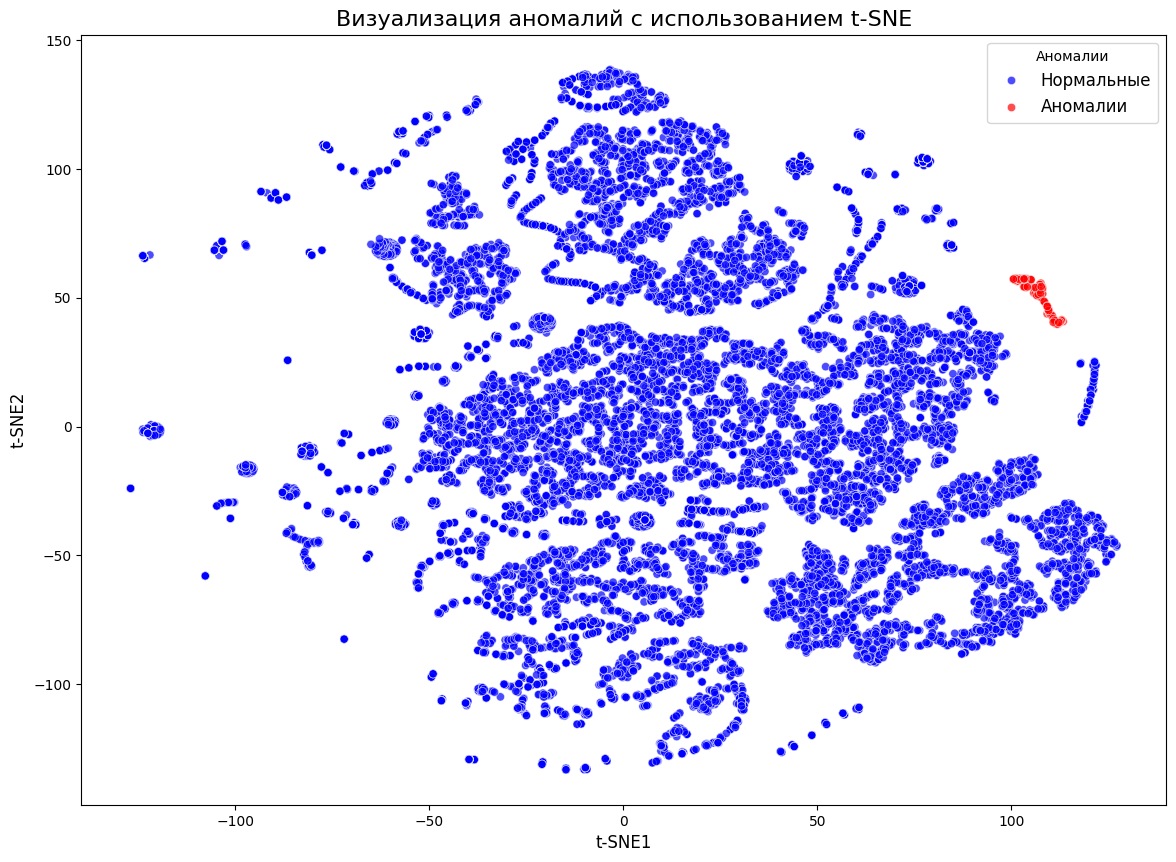

In [ ]:
plt.figure(figsize=(14, 10))

# Визуализация на основе оценки аномальности
sns.scatterplot(
    x='t-SNE1',
    y='t-SNE2',
    hue=anomaly_labels_test,  # Цветовая кодировка на основе меток аномальности
    data=data_test,
    palette={0: 'blue', 1: 'red'},  # Нормальные — синим, аномальные — красным
    alpha=0.7
)

# Заголовок и подписи
plt.title("Визуализация аномалий с использованием t-SNE", fontsize=16)
plt.xlabel("t-SNE1", fontsize=12)
plt.ylabel("t-SNE2", fontsize=12)

# Ручная настройка легенды
handles, labels = plt.gca().get_legend_handles_labels()
# Изменяем метки на 'Нормальные' и 'Аномалии'
plt.legend(handles, ['Нормальные', 'Аномалии'], title='Аномалии', fontsize=12)

# Показать график
plt.show()

In [ ]:
src_ip_list = X_test_anomal.index.tolist()
filtered_data = ip_requests_distribution_1.loc[src_ip_list]

Группируем аномальные значения в отдельный DataFrame filtered_data

In [ ]:
filtered_data

,median,max,min,sum,count_peaks,CV
src_ip,,,,,,
64885,1.5,99,1,135,1,1.747690
20355,1.0,6,1,965,28,0.530525
44048,19.0,19,19,19,0,0.000000
72334,48.5,56,41,97,1,0.218693
68848,23.0,23,23,23,0,0.000000
...,...,...,...,...,...,...
89971,1.0,79,1,692,10,2.279652
72269,24.0,24,24,24,0,0.000000
16882,1.0,69,1,190,5,3.702317


Распределенние аномальных значений

In [ ]:
filtered_data.describe()

,median,max,min,sum,count_peaks,CV
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,22.238636,57.909091,14.575758,2448.825758,10.219697,0.699613
std,17.233961,59.388545,12.892463,7471.279277,26.809852,0.846286
min,1.000000,5.000000,1.000000,17.000000,0.000000,0.000000
25%,5.000000,23.000000,1.000000,36.750000,0.000000,0.000000
50%,21.000000,39.500000,17.000000,88.000000,1.000000,0.414358
75%,32.125000,75.500000,23.000000,252.500000,2.000000,0.884003
max,91.000000,516.000000,67.000000,49146.000000,147.000000,3.702317


Группируем нормальные значения в отдельный DataFrame filtered_data_normal

In [ ]:
src_ip_list_normal = X_test_normal.index.tolist()
filtered_data_normal = ip_requests_distribution_1.loc[src_ip_list_normal]
filtered_data_normal

,median,max,min,sum,count_peaks,CV
src_ip,,,,,,
106675,14.0,18,1,33,1,0.808018
27925,5.0,5,5,5,0,0.000000
37508,8.0,32,1,63,1,1.077438
97674,14.0,14,1,29,0,0.776437
69824,5.5,9,2,11,1,0.899954
...,...,...,...,...,...,...
20920,3.0,5,1,6,1,0.942809
42370,8.0,66,1,423,2,1.174297
5303,1.0,1,1,2,0,0.000000


Распределенние нормальных значений

In [ ]:
filtered_data_normal.describe()

,median,max,min,sum,count_peaks,CV
count,21218.000000,21218.000000,21218.000000,21218.000000,21218.000000,21218.000000
mean,7.457395,25.575172,1.621595,119.112452,0.985673,0.725190
std,5.629809,25.462520,1.905912,221.624797,0.950727,0.433750
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,9.000000,1.000000,16.000000,1.000000,0.506860
50%,7.000000,18.000000,1.000000,41.000000,1.000000,0.794719
75%,10.000000,33.000000,1.000000,135.000000,1.000000,1.013794
max,69.000000,179.000000,19.000000,5555.000000,24.000000,2.170349


## Сравнение распределения данных в test(до нормализации) отнесенных моделью к нормальным и аномальным значениямя.
1. Признак median (медианное значение):
- Нормальные данные: Среднее значение — 7.46, стандартное отклонение — 5.63.
- Аномальные данные: Среднее значение — 22.24, стандартное отклонение — 17.23.
Сравнение: Аномальные точки имеют значительно более высокую медиану, что говорит о том, что они характеризуются значительно более высокими базовыми значениями.
2. Признак max (максимальное значение):
- Нормальные данные: Среднее значение — 25.58, стандартное отклонение — 25.46.
- Аномальные данные: Среднее значение — 57.91, стандартное отклонение — 59.39.
Сравнение: Аномальные точки имеют значительно более высокие максимальные значения, в частности максимум у аномалий достигает 516, тогда как у нормальных максимум — 179. Это указывает на выбросы в пиках.
3. Признак min (минимальное значение):
- Нормальные данные: Среднее значение — 1.62, стандартное отклонение — 1.91.
- Аномальные данные: Среднее значение — 14.58, стандартное отклонение — 12.89.
Сравнение: Аномальные точки имеют значительно более высокие минимальные значения, что говорит о том, что даже их базовые уровни значительно выше.
4. Признак sum (суммарное значение):
- Нормальные данные: Среднее значение — 119.11, стандартное отклонение — 221.62.
- Аномальные данные: Среднее значение — 2448.83, стандартное отклонение — 7471.28.
Сравнение: Аномальные точки имеют значительно более высокие суммарные значения. Максимальная сумма у аномалий достигает 49146, что многократно превышает максимум у нормальных (5555).
5. Признак count_peaks (количество пиков):
- Нормальные данные: Среднее значение — 0.99, стандартное отклонение — 0.95.
- Аномальные данные: Среднее значение — 10.22, стандартное отклонение — 26.81.
Сравнение: Аномальные точки имеют значительно больше пиков (в среднем 10), тогда как у нормальных значение стремится к 1. Максимальное количество пиков у аномалий (147) также значительно превышает нормальные данные (24).
6. Признак CV (коэффициент вариации):
- Нормальные данные: Среднее значение — 0.73, стандартное отклонение — 0.43.
- Аномальные данные: Среднее значение — 0.70, стандартное отклонение — 0.85.
Сравнение: Для данного признака значения нормальных и аномальных точек сходны, но у аномальных точек наблюдается больший разброс (стандартное отклонение).